LAST RUN BY: CAM 07/02/2020

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Get-TF-enrichments-for-top-20-genes-in-each-component" data-toc-modified-id="Get-TF-enrichments-for-top-20-genes-in-each-component-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Get TF enrichments for top 20 genes in each component</a></span></li><li><span><a href="#Sensitivity-Analysis" data-toc-modified-id="Sensitivity-Analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Sensitivity Analysis</a></span></li></ul></div>

In [1]:
import sys
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

In [2]:
sys.path.append('..')
from icaviz.load import *

In [3]:
DATA_DIR = '../data/precise2_data/'
GENE_DIR = '../data/annotation/'
X_file = DATA_DIR + 'log_tpm_qc.csv'
S_file = DATA_DIR + 'S.csv'
A_file = DATA_DIR + 'A.csv'
metadata_file = DATA_DIR+'metadata_qc.csv'
annotation_file = GENE_DIR + 'gene_info.csv'
trn_file = GENE_DIR + 'TRN.csv'

In [4]:
# Load ica_data object    
ica_data = load_data(X_file,S_file,A_file,
                     metadata_file,annotation_file,
                     trn_file)

../icaviz/load.py:350: UserWarning: Genes missing annotations: b0012, b0056, b0057, b4726, b4727, b4728, b4710, b4709, b4729, b0282, b4730, b0322, b4731, b4732, b0470_1, b0470_2, b0470_3, b0484_1, b0484_2, b0484_3, b0502, b4733, b0562, b4734, b4581, b4735, b4736, b4723, b4737, b4490, b1142, b1149, b4738, b4739, b4491, b4521, b4740, b1228, b4573, b4711, b4741, b4742, b1318, b4524, b4743, b4744, b4493, b4745, b1459, b1470, b1471, b4746, b4747, b1506, b4696, b1543, b4748, b4749, b4724, b4750, b4534, b4494, b4751, b4752, b4495, b4496, b2092, b2115, b2139, b4604, b4605, b4725, b2641, b4644, b2649, b2681, b4610, b2850, b2854, b2855, b2858, b2862, b4753, b4754, b2941, b4658, b4755, b3036, b4756, b3268, b3423, b4612, b4660, b4615, b3643, b3681, b3682, b4757, b4488, b3777, b3782, b3808, b4038, b4583, b4223, b4575, b4308, b4720, b4721, b4722, b4715, b4584
  warnings.warn('Genes missing annotations: {}'.format(missing_genes))


# Get TF enrichments for top 20 genes in each component
The mean number of genes in an *E. coli* regulon is 30, and the median is 6.

In [5]:
# Some versions of pandas activate an internal FutureWarning, so we will quiet those

import warnings
warnings.filterwarnings('ignore',category=FutureWarning)

In [6]:
# Initialize objects
list2struct = []

all_genes = set(ica_data.S.index)

for k in tqdm(ica_data.S.columns):
    # Get top 20 genes
    genes = set(abs(ica_data.S[k]).sort_values().iloc[-20:].index)

    # Compute single TF enrichments
    enrichments = compute_enrichments(genes, all_genes, 
                                      ica_data.trn, max_tfs=1, 
                                      fdr_rate=1e-5)
    enrichments['TF'] = enrichments.index
    enrichments['component'] = k
    enrichments['n_genes'] = len(genes)

    list2struct.append(enrichments.reset_index(drop=True))
    
DF_enriched = pd.concat(list2struct, sort=False).reset_index(drop=True)
DF_enriched = DF_enriched[['component', 'TF', 'log_odds', 
                           'pvalue', 'qvalue','precision',
                           'recall','f1score','TP', 'n_genes','n_tf']]
    
# Sort by p-value
DF_enriched = DF_enriched.sort_values(['component','qvalue']).drop_duplicates('component')
DF_enriched = DF_enriched.set_index('component')
DF_enriched.head()

/Users/cam/.virtualenvs/modulome/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


,TF,log_odds,pvalue,qvalue,precision,recall,f1score,TP,n_genes,n_tf
component,,,,,,,,,,
1,cysB,5.283896,1.609825e-17,4.394822e-15,0.50,0.312500,0.384615,10.0,20,1.0
2,yiaJ,8.379769,2.867916e-24,7.829410e-22,0.50,0.909091,0.645161,10.0,20,1.0
3,phoB,6.391577,1.004983e-30,2.743603e-28,0.85,0.293103,0.435897,17.0,20,1.0
4,ntrC,4.809555,5.275447e-17,1.440197e-14,0.55,0.203704,0.297297,11.0,20,1.0
7,prpR,6.993474,1.578694e-09,4.309835e-07,0.20,0.800000,0.320000,4.0,20,1.0


In [7]:
print('Total components:',len(ica_data.S.columns))
print('Components with regulator enrichments:',len(DF_enriched))
print('Unique regulators:',len(DF_enriched.TF.unique()))

Total components: 229
Components with regulator enrichments: 95
Unique regulators: 73


# Sensitivity Analysis
To identify the best cutoff, we can scan across various cutoffs to identify the best results. 

In [8]:
precision = []
recall = []
fpr = []
f1_score = []
all_genes = set(ica_data.S.index)
vals = np.arange(300,900,25)

for cutoff in tqdm(vals):
    prec = []
    rec = []
    f1_i = []
    fpr_i = []

    for i,row in DF_enriched.iterrows():
        
        # Get threshold based on test-statistic cutoff
        thresh = compute_threshold(ica_data.S,i,cutoff)
        
        # Get genes in i-modulon
        ic_genes = set(ica_data.S[abs(ica_data.S[i]) > thresh].index)
        
        # Get genes in linked regulon
        reg_genes = set(ica_data.trn[ica_data.trn.TF == row.TF].gene_id)
        
        # Compute contingency table
        ((tp_i,fp_i),(fn_i,tn_i)) = contingency(reg_genes,ic_genes,all_genes)

        # Calculate metrics for one regulator-component pair
        prec_tmp = np.true_divide(tp_i,tp_i+fp_i)
        rec_tmp = np.true_divide(tp_i,tp_i+fn_i)
        f1_tmp = (2*prec_tmp*rec_tmp)/(prec_tmp+rec_tmp) if prec_tmp + rec_tmp > 0 else 0
        fpr_tmp = np.true_divide(fp_i,fp_i+tn_i)

        # Add to list for this cutoff score
        prec.append(prec_tmp)
        rec.append(rec_tmp)
        f1_i.append(f1_tmp)
        fpr_i.append(fpr_tmp)

    # Get mean of metric for this cutoff score
    precision.append(np.mean(prec))
    recall.append(np.mean(rec))
    fpr.append(np.mean(fpr_i))
    f1_score.append(np.mean(f1_i))

/Users/cam/.virtualenvs/modulome/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


The [F1-score](https://en.wikipedia.org/wiki/F1_score) measures the balance between [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall).

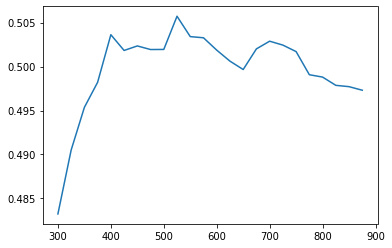

In [9]:
plt.plot(vals,f1_score)

In [10]:
print('Max F1-score:',max(f1_score))
print('Cutoff value:',vals[np.argmax(f1_score)])

Max F1-score: 0.5057255694116808
Cutoff value: 525


Text(0.5, 1.0, 'ROC Curve')

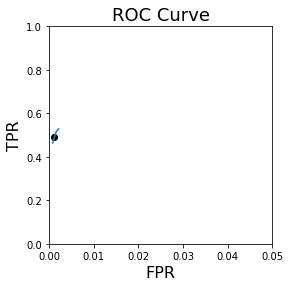

In [11]:
fig,ax = plt.subplots(figsize=(4,4))
plt.plot(fpr,recall)
plt.xlabel('FPR',fontsize=16)
plt.ylabel('TPR',fontsize=16)
plt.scatter([fpr[np.argmax(f1_score)]],[recall[np.argmax(f1_score)]],color='k')
plt.xlim([0,0.05])
plt.ylim([0,1])
plt.title('ROC Curve',fontsize=18)

Text(0.5, 1.0, 'Precision-Recall Curve')

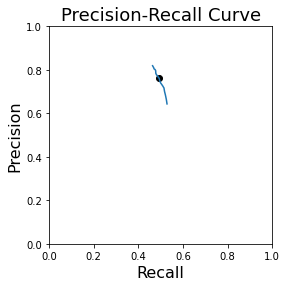

In [12]:
fig,ax = plt.subplots(figsize=(4,4))
plt.plot(recall,precision)
plt.xlabel('Recall',fontsize=16)
plt.ylabel('Precision',fontsize=16)
plt.scatter([recall[np.argmax(f1_score)]],[precision[np.argmax(f1_score)]],color='k')
plt.xlim([0,1])
plt.ylim([0,1])
plt.title('Precision-Recall Curve',fontsize=18)